In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

In [3]:
data=pd.read_csv('Fraud.csv')

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   nameOrig        object 
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   nameDest        object 
 6   oldbalanceDest  float64
 7   newbalanceDest  float64
 8   isFraud         int64  
 9   isFlaggedFraud  int64  
 10  balance_org     float64
 11  balance_dest    float64
dtypes: float64(7), int64(2), object(3)
memory usage: 582.5+ MB


In [37]:
print(data['isFraud'].value_counts())
print(data['isFlaggedFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64


In [38]:
def missing_values(data):
    for col in data.columns:
        missing=data[col].isnull().sum()
        print(f'Missing value in {col} is {missing}')
missing_values(data)

Missing value in type is 0
Missing value in amount is 0
Missing value in nameOrig is 0
Missing value in oldbalanceOrg is 0
Missing value in newbalanceOrig is 0
Missing value in nameDest is 0
Missing value in oldbalanceDest is 0
Missing value in newbalanceDest is 0
Missing value in isFraud is 0
Missing value in isFlaggedFraud is 0
Missing value in balance_org is 0
Missing value in balance_dest is 0


In [39]:
# percentag eof data that is fraud
fraud_percentage = (data['isFraud'].sum() / len(data)) * 100
print(f"Percentage of data that is fraud: {fraud_percentage:.2f}%")

Percentage of data that is fraud: 0.13%


In [40]:
missing_values(data)

Missing value in type is 0
Missing value in amount is 0
Missing value in nameOrig is 0
Missing value in oldbalanceOrg is 0
Missing value in newbalanceOrig is 0
Missing value in nameDest is 0
Missing value in oldbalanceDest is 0
Missing value in newbalanceDest is 0
Missing value in isFraud is 0
Missing value in isFlaggedFraud is 0
Missing value in balance_org is 0
Missing value in balance_dest is 0


<function matplotlib.pyplot.show(close=None, block=None)>

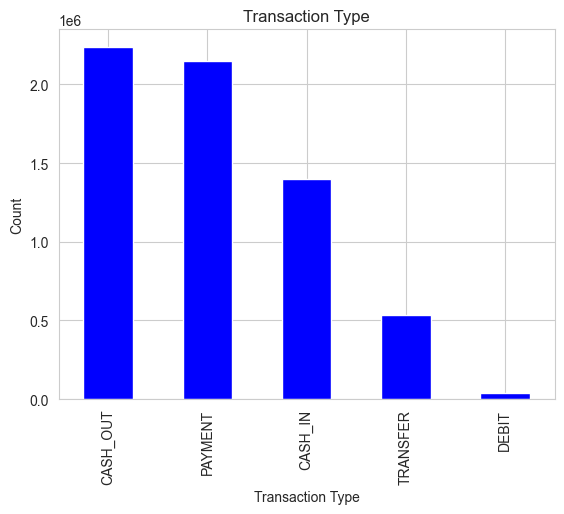

In [9]:
data['type'].value_counts().plot(kind='bar',title='Transaction Type',color='blue')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

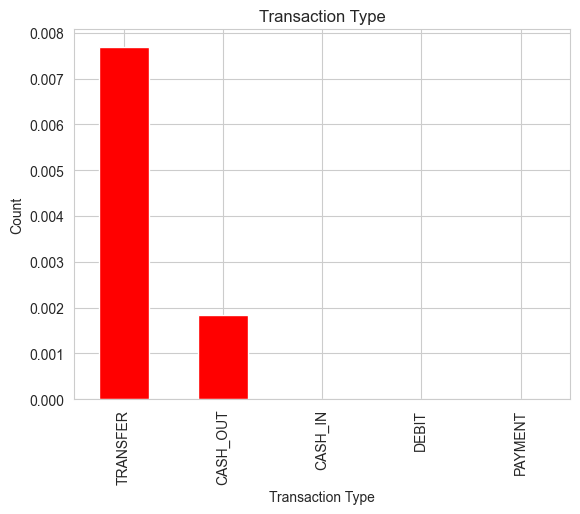

In [10]:
# plotting number of fraud based on type
is_fraud=data.groupby('type')['isFraud'].mean().sort_values(ascending=False)
is_fraud.plot(kind='bar',title='Transaction Type',color='red')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show

In [11]:
data['amount'].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

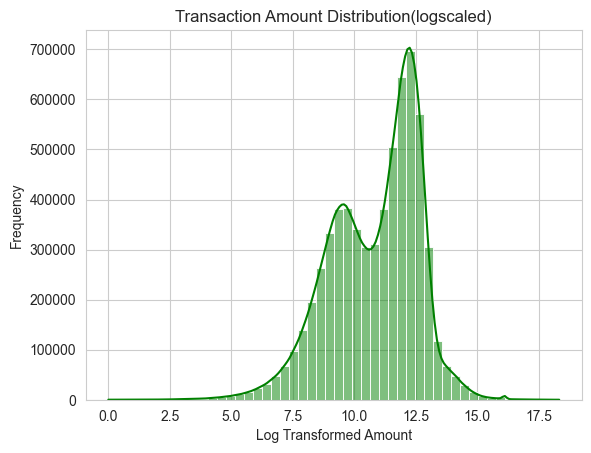

In [12]:
sns.histplot(np.log1p(data['amount']),bins=50,kde=True,color='Green')
plt.title('Transaction Amount Distribution(logscaled)')
plt.xlabel('Log Transformed Amount')
plt.ylabel('Frequency')
plt.show()

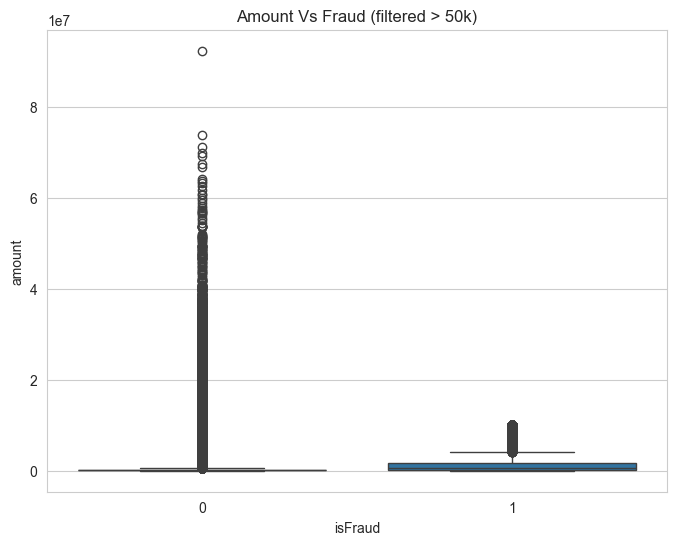

In [13]:
plt.figure(figsize=(8,6))
sns.boxplot(data=data[data['amount'] > 50000], x='isFraud', y='amount')
plt.title('Amount Vs Fraud (filtered > 50k)')
plt.show()


In [14]:
data['balance_org']=data['oldbalanceOrg']-data['newbalanceOrig']
data['balance_dest']=data['oldbalanceDest']-data['newbalanceDest']


In [15]:
(data['balance_org']<0).sum()

1399253

In [16]:
(data['balance_dest']<0).sum()

2806464

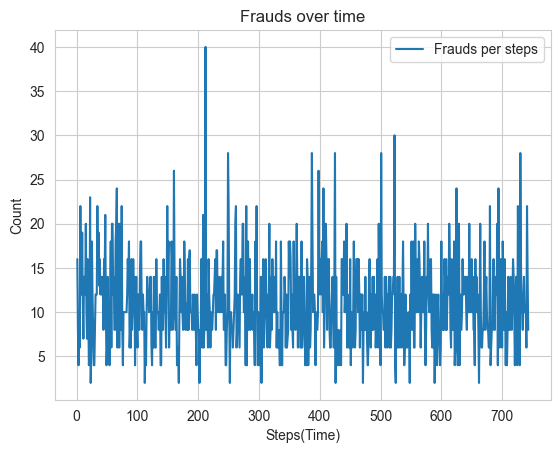

In [17]:
fraud_per_step=data[data['isFraud']==1]['step'].value_counts().sort_index()
plt.plot(fraud_per_step.index,fraud_per_step.values,label='Frauds per steps')
plt.xlabel('Steps(Time)')
plt.ylabel('Count')
plt.title( 'Frauds over time')
plt.legend()
plt.show()

In [18]:
data.drop(columns='step',inplace=True)

In [19]:
top_senders=data['nameOrig'].value_counts().head(10)
top_receivers=data['nameDest'].value_counts().head(10)


In [20]:
top_senders

nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
C1677795071    3
C1462946854    3
C1999539787    3
C2098525306    3
C400299098     3
Name: count, dtype: int64

In [21]:
top_receivers

nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
C1590550415    101
C451111351      99
C1789550256     99
C1360767589     98
C1023714065     97
Name: count, dtype: int64

In [22]:
fraud_users=data[data['isFraud']==1]['nameOrig'].value_counts()
fraud_users.head(10)

nameOrig
C1305486145    1
C755286039     1
C973279667     1
C258213312     1
C1640703547    1
C1127265876    1
C317779855     1
C1064034527    1
C1141104763    1
C1966863341    1
Name: count, dtype: int64

In [23]:
fraud_type=data[data['type'].isin(['CASH_OUT','TRANSFER'])]
fraud_type['type'].value_counts()

type
CASH_OUT    2237500
TRANSFER     532909
Name: count, dtype: int64

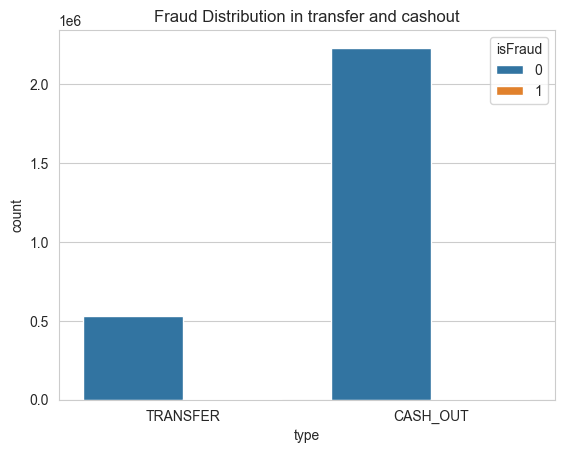

In [24]:
sns.countplot(data=fraud_type,x='type',hue='isFraud')
plt.title('Fraud Distribution in transfer and cashout')
plt.show()

In [25]:
data.columns


Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'balance_org', 'balance_dest'],
      dtype='object')

In [26]:
correlation=data[['amount','oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest']].corr()
correlation

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
amount,1.000000,-0.002762,-0.007861,0.294137,0.459304
oldbalanceOrg,-0.002762,1.000000,0.998803,0.066243,0.042029
newbalanceOrig,-0.007861,0.998803,1.000000,0.067812,0.041837
oldbalanceDest,0.294137,0.066243,0.067812,1.000000,0.976569
newbalanceDest,0.459304,0.042029,0.041837,0.976569,1.000000


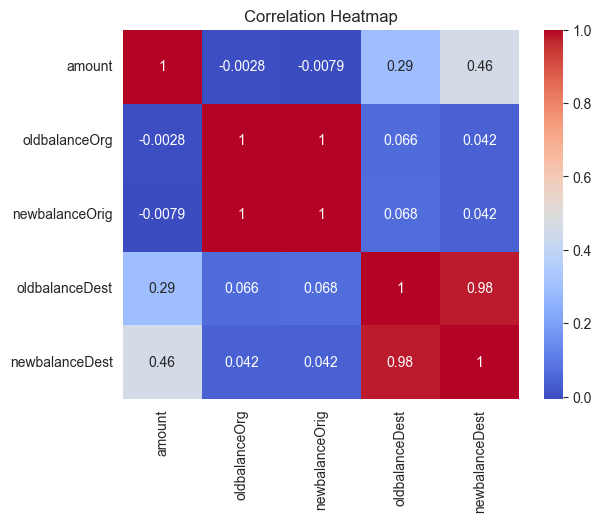

In [27]:
sns.heatmap(correlation,annot=True,cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [28]:
zero_after_payment=data[
    (data['oldbalanceOrg']>0) &
    (data['newbalanceOrig']==0)&
    (data['type'].isin(['TRANSFER','CASH_OUT']))]
len(zero_after_payment)


1188074

In [29]:
# Feature Engineering
data1=data.drop(columns=['nameOrig','nameDest'])
data1=data1.drop(columns=['isFlaggedFraud'])


In [30]:
categorical=['type']
numerical=['amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest','balance_org', 'balance_dest']
X=data1.drop('isFraud',axis=1)
y=data1[['isFraud']]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
X.columns

Index(['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'balance_org', 'balance_dest'],
      dtype='object')

In [52]:
# preprocessing
preprocessor=ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),numerical),
        ('cat',OneHotEncoder(handle_unknown='ignore'),categorical)
    ],remainder='drop')
log_pipeline=Pipeline([
    ('preprocessor',preprocessor),
    ('clf',LogisticRegression(class_weight='balanced',max_iter=1000))
])
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', XGBClassifier(
        n_estimators=200,         # number of boosting rounds
        learning_rate=0.1,        # shrinkage step
        max_depth=6,              # tree depth
        subsample=0.8,            # sampling rows
        colsample_bytree=0.8,     # sampling features
        scale_pos_weight=10,      # imbalance handling (adjust based on ratio of fraud:non-fraud)
        eval_metric='auc',        # evaluation metric
        random_state=42,
        use_label_encoder=False
    ))
])

Fitting training and testing data in model


In [55]:
log_pipeline.fit(X_train,y_train)
xgb_pipeline.fit(X_train,y_train)


,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [59]:
y_pred_log=log_pipeline.predict(X_test)
y_pred_xgb=xgb_pipeline.predict(X_test)

In [58]:
from sklearn.metrics import accuracy_score

print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_log))
print("Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))


Accuracy (Logistic Regression): 0.946499502825356
Accuracy (XGBoost): 0.9993938555710279


In [60]:
print(f'Classification Report on fraud detection model by XGBoost Classifier is :',classification_report(y_test,y_pred_xgb))

Classification Report on fraud detection model by XGBoost Classifier is :               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.93      0.80      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.97      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786



In [61]:
print(f'Confusion Matrix XGB',confusion_matrix(y_test,y_pred_xgb))


Confusion Matrix XGB [[1905354     997]
 [    160    2275]]


In [62]:
import joblib
joblib.dump(log_pipeline, "logistic_model.pkl")
joblib.dump(xgb_pipeline, "xgboost_model.pkl")
log_model = joblib.load("logistic_model.pkl")
xgb_model = joblib.load("xgboost_model.pkl")


NameError: name 'new_data' is not defined